# Modeling

In [260]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler


import xgboost as xgb
from xgboost import plot_importance

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

import eli5
import shap
import pickle

import warnings
warnings.filterwarnings("ignore")

random_state = 777

# Load Data

In [141]:
src = pd.read_csv('data/01_cleansed.csv', index_col=0)
print(src.shape)

(316821, 26)


# Preprocessing

## Functions

In [308]:
# Basic cleaning
def clean(df):
    data = df.copy()
    
    # convert to float
    for col in ['loan_amnt','revol_bal']:
        data[col] = data[col].astype(float)
    # earlies_cr_line : datetime
    data.earliest_cr_line = pd.to_datetime(data.earliest_cr_line)
    # trim 
    cat_cols = ['term','grade','sub_grade','emp_length','home_ownership',
                'purpose','initial_list_status','application_type']
    for col in cat_cols:
        data[col] = data[col].str.strip()
    # lowercase
    lower_cols = ['emp_title','title','purpose']
    for col in lower_cols:
        data[col] = data[col].str.lower()
        
    # according to data dict home_ownership only has 4 possible values
    home_ownership_levels = ['MORTGAGE','RENT','OWN','OTHER']
    data.home_ownership = np.where(src.home_ownership.isin(home_ownership_levels), src.home_ownership, 'OTHER')
    
    return data

# Make category variables
def make_categories(df):
    data = df.copy()
    
    # encode target variable
    data.loan_status = data.loan_status.map({'Charged Off': 0,'Fully Paid': 1})
    
    nominal_cats = {
        'home_ownership' : ['MORTGAGE','RENT','OWN','OTHER'],
        'purpose' : ['debt_consolidation', 'credit_card', 'home_improvement', 'other',
                       'major_purchase', 'small_business', 'car', 'medical', 'moving',
                       'vacation', 'house', 'wedding', 'renewable_energy', 'educational'],
        'initial_list_status' : ['f','w'],
        'application_type' : ['INDIVIDUAL', 'JOINT', 'DIRECT_PAY'],
        'verification_status' : ['Not Verified', 'Verified', 'Source Verified'],
    }
    ordinal_cats = {
        'term' : ['36 months', '60 months'],
        'grade' : ['A','B','C','D','E','F','G'],
        'sub_grade' : ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 
                       'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 
                       'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 
                       'G1', 'G2', 'G3', 'G4', 'G5'],
        'emp_length' : ['None', '< 1 year', '1 year', '2 years', '3 years', '4 years', 
                        '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years'],
    }
    for col, categories in nominal_cats.items():
        data[col] = data[col].astype(pd.CategoricalDtype(categories=categories))

    for col, categories in ordinal_cats.items():
        data[col] = data[col].astype(pd.CategoricalDtype(categories=categories, ordered=True))
    
    data.emp_length = data.emp_length.fillna('None')
    return data

# Featurization
def featurize(df):
    data = df.copy()
    data['inc_not_verified'] = data.verification_status.eq('Not Verified').astype(int)
    data['earliest_cr_year'] = data.earliest_cr_line.dt.year.astype(int)
    # data['earliest_cr_year_adj'] = data.earliest_cr_year.apply(lambda x: x if x < 2013 else 2013)
    data['revol_util_missing'] = data.revol_util.isna().astype(int)
    data['mort_acc_missing'] = data.mort_acc.isna().astype(int)
    data['pub_rec_bankrupt_missing'] = data.pub_rec_bankruptcies.isna().astype(int)
    data['zip'] = data.address.str.split('[\s,]', regex=True).apply(lambda x: x[-1]).astype('category')
    # data['state'] = data.address.str.split('[\s,]', regex=True).apply(lambda x: x[-2]).astype('category')
    data['installment_inc_ratio'] = data['installment'] / data['annual_inc'] * 12
    return data

# drop text and dates after feature generating is done
def drop_unused_features(df):
    data = df.copy()
    cols = ['address','emp_title', 'title','earliest_cr_line']
    data = data.drop(columns=cols)
    return data

def impute(df):
    data = df.copy()
    data.revol_util = data.revol_util.fillna(0)
    data.mort_acc = data.mort_acc.fillna(0).astype(int)
    data.pub_rec_bankruptcies = data.pub_rec_bankruptcies.fillna(0).astype(int)    
    return data

# category encoding functions
def label_encode(df, cols=None):
    if not cols:
        cols = df.columns
    cols = [col for col in cols if col in df.columns]         
    data = df.copy()
    for col in cols:
        if data[col].dtype == 'category':
            data[col] = data[col].cat.codes
    return data

def onehot_encode(df, cols):
    cols = [col for col in cols if col in df.columns] 
    data = pd.get_dummies(df, columns=cols)
    return data

ord_cols = list(ordinal_cats.keys()) 
nom_cols = list(nominal_cats.keys()) + ['zip']

## Processing

In [309]:
df = clean(src)
df = make_categories(df)
df = featurize(df)
df = impute(df)
df = drop_unused_features(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316821 entries, 1 to 396029
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   loan_amnt                 316821 non-null  float64 
 1   term                      316821 non-null  category
 2   int_rate                  316821 non-null  float64 
 3   installment               316821 non-null  float64 
 4   grade                     316821 non-null  category
 5   sub_grade                 316821 non-null  category
 6   emp_length                316821 non-null  category
 7   home_ownership            316821 non-null  category
 8   annual_inc                316821 non-null  float64 
 9   verification_status       316821 non-null  category
 10  loan_status               316821 non-null  int64   
 11  purpose                   316821 non-null  category
 12  dti                       316821 non-null  float64 
 13  open_acc                  316

# Train / Validation / Test

In [310]:
test_size = 0.2
val_size = 0.2

X = df.copy()
y = X.pop('loan_status')

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=val_size/(1-test_size), random_state=random_state)

print(f"Train: {X_train.shape[0]} samples, {X_train.shape[0]/X.shape[0]:.2%}, pos labels: {y_train.mean():.2%}")
print(f"Valid: {X_val.shape[0]} samples, {X_val.shape[0]/X.shape[0]:.2%}, pos labels: {y_val.mean():.2%}")
print(f"Test:  {X_test.shape[0]} samples, {X_test.shape[0]/X.shape[0]:.2%}, pos labels: {y_test.mean():.2%}")

Train: 190092 samples, 60.00%, pos labels: 84.26%
Valid: 63364 samples, 20.00%, pos labels: 84.12%
Test:  63365 samples, 20.00%, pos labels: 84.28%


In [311]:
train_data = pd.concat([X_train, y_train], axis='columns')
val_data = pd.concat([X_val, y_val], axis='columns')
test_data = pd.concat([X_test, y_test], axis='columns')
dev_data = pd.concat([X_dev, y_dev], axis='columns')

# Evaluate Mutual Information

Check mutual information between each of the predictors and the target.

In [312]:
# MI score helper
def make_mi_scores(X, y, discrete_features='auto'): 
    # let the function decide what is discrete variable automatically
	mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=random_state)
	mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
	mi_scores = mi_scores.sort_values(ascending=False)
	return mi_scores

def plot_mi_scores(mi_scores, figsize=(6,9)):
    mi_scores.sort_values().plot.barh(figsize=figsize, title='Mutual Information Scores');

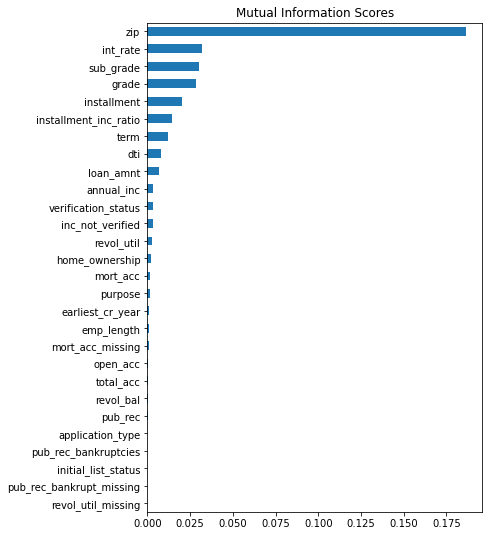

In [313]:
X = dev_data.copy()
y = X.pop('loan_status')

X = label_encode(X)

discrete_features = (X.dtypes != 'float')
mi_scores = make_mi_scores(X, y, discrete_features=discrete_features)
plot_mi_scores(mi_scores)

# Train Model

In [485]:
# Preprocessing
def preprocess(df):
    X = df.copy()
    
    drop_cols = ['grade','verification_status',
                 'revol_util_missing', 'pub_rec_bankrupt_missing']
    X = X.drop(columns=drop_cols)
    
    # label encoding all categorical variables
    X = label_encode(X)
    
    # ordinal + onehot
    # X = label_encode(X, ord_cols)
    # X = onehot_encode(X, nom_cols)

    return X

X_train = train_data.copy()
y_train = X_train.pop('loan_status')
X_train = preprocess(X_train)

X_val = val_data.copy()
y_val = X_val.pop('loan_status')
X_val = preprocess(X_val)

X_test = test_data.copy()
y_test = X_test.pop('loan_status')
X_test = preprocess(X_test)

X_dev = dev_data.copy()
y_dev = X_dev.pop('loan_status')
X_dev = preprocess(X_dev)

Default Params
Train ROC-AUC: 0.9171206916815662
Valid ROC-AUC: 0.9066259057025039
Test  ROC-AUC: 0.9090001122717211


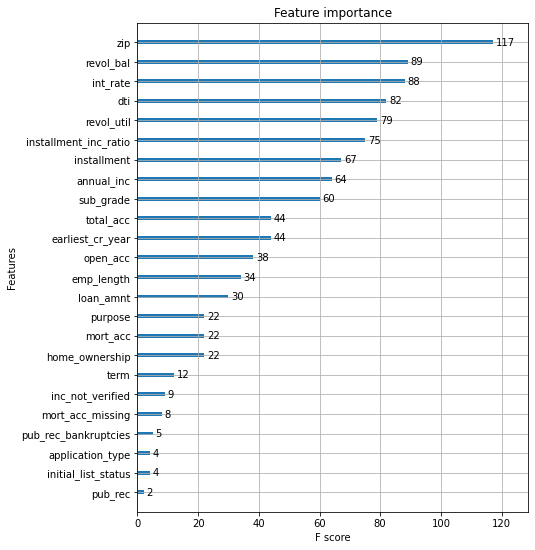

In [486]:
# features = df.columns
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
xgb_params = {'objective': 'binary:logistic', 
              'random_state': random_state,
              'eval_metric': 'auc',
              'scale_pos_weight' : scale_pos_weight,
              }

eval_set = [(X_train, y_train), (X_val, y_val)]
model = xgb.XGBClassifier(**xgb_params)
model = model.fit(X_train, y_train, eval_set=eval_set, 
                early_stopping_rounds=5, 
                eval_metric='auc', verbose=False)
auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
auc_val = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

print("Default Params")
print(f"Train ROC-AUC: {auc_train}")
print(f"Valid ROC-AUC: {auc_val}")
print(f"Test  ROC-AUC: {auc_test}")

fig, ax = plt.subplots(figsize=(7,9))
plot_importance(model, ax=ax)
plt.show()

## Experiment: Resampling

Experiment with imbalanced handling methods

In [515]:
def experiment_resampler(resampler, name):

    X_train_rs, y_train_rs = resampler.fit_resample(X_train, y_train)
    X_train_rs = pd.DataFrame(X_train_rs, columns=X_train.columns)
    y_train_rs = pd.Series(y_train_rs, name=y_train.name)
    
    xgb_params = {'objective': 'binary:logistic', 
              'random_state': random_state,
              'eval_metric': 'auc',
              # already equal weight
              # 'scale_pos_weight' : scale_pos_weight, 
              }

    eval_set = [(X_train_rs, y_train_rs), (X_val, y_val)]


    model = xgb.XGBClassifier(**xgb_params)
    model = model.fit(X_train_rs, y_train_rs, eval_set=eval_set, 
                    early_stopping_rounds=5, 
                    eval_metric='auc', verbose=False)
    auc_train = roc_auc_score(y_train_rs, model.predict_proba(X_train_rs)[:,1])
    auc_val = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    print(f"{name}")
    print(f"Train ROC-AUC: {auc_train}")
    print(f"Valid ROC-AUC: {auc_val}")
    print(f"Test  ROC-AUC: {auc_test}")
    return auc_train, auc_val, auc_test

rs_names = ['Under-sampling', 'Over-sampling', 'SMOTE']
resamplers = [
    RandomUnderSampler(random_state=random_state),
    RandomOverSampler(random_state=random_state),
    SMOTE(random_state=random_state)
]

for rs, name in zip(resamplers, rs_names):
    experiment_resampler(rs, name)
    print()

Under-sampling
Train ROC-AUC: 0.923352048737829
Valid ROC-AUC: 0.9061585948115053
Test  ROC-AUC: 0.9074726958743031

Over-sampling
Train ROC-AUC: 0.9181939879987974
Valid ROC-AUC: 0.9060243616030502
Test  ROC-AUC: 0.9083910183495583

SMOTE
Train ROC-AUC: 0.9159269354407712
Valid ROC-AUC: 0.8607229819993938
Test  ROC-AUC: 0.8644606501230184



Resampling doesn't help much - SMOTE even overfits.

## Tuning a bit

In [512]:
# tweak some parameters
xgb_params = {'objective': 'binary:logistic', 
              'random_state': random_state,
              'eval_metric': 'auc',
              'scale_pos_weight' : scale_pos_weight,
              'n_estimators' : 500,
              'max_depth' : 3,
              'learning_rate' : .2,
              'reg_alpha' : 5,   # 10
              'reg_lambda' : 5, #11
              }

eval_set = [(X_train, y_train), (X_val, y_val)]
model = xgb.XGBClassifier(**xgb_params)
model = model.fit(X_train, y_train, eval_set=eval_set, 
                early_stopping_rounds=5, 
                eval_metric='auc', verbose=False)
auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
auc_val = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

print("Parameters tuned")
print(f"Train ROC-AUC: {auc_train}")
print(f"Valid ROC-AUC: {auc_val}")
print(f"Test  ROC-AUC: {auc_test}")

Parameters tuned
Train ROC-AUC: 0.9170739914691901
Valid ROC-AUC: 0.9088287572829927
Test  ROC-AUC: 0.9102977659100737


## Final Model

In [517]:
xgb_params = {'objective': 'binary:logistic', 
              'random_state': random_state,
              'eval_metric': 'auc',
              'scale_pos_weight' : scale_pos_weight,
              'n_estimators' : 500,
              'max_depth' : 3,
              'learning_rate' : .2,
              'reg_alpha' : 5,
              'reg_lambda' : 5, 
              }

# not using the test set to evaluate, to make sure that test set is really untouched - No cheating!
eval_set = [(X_dev, y_dev)]
model = xgb.XGBClassifier(**xgb_params)
model = model.fit(X_dev, y_dev, eval_set=eval_set, 
                early_stopping_rounds=5, 
                eval_metric='auc', verbose=False)
auc_train = roc_auc_score(y_dev, model.predict_proba(X_dev)[:,1])
auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

print(f"Train ROC-AUC: {auc_train}")
print(f"Test  ROC-AUC: {auc_test}")

Train ROC-AUC: 0.9199659619729119
Test  ROC-AUC: 0.9106167289782804


# Performance metrics

Evaluate model performance on `Test Set`

In [519]:
y_dev_pred = model.predict(X_dev)
y_dev_score = model.predict_proba(X_dev)[:,1]
y_test_pred = model.predict(X_test)
y_test_score = model.predict_proba(X_test)[:,1]

## ROC Curve

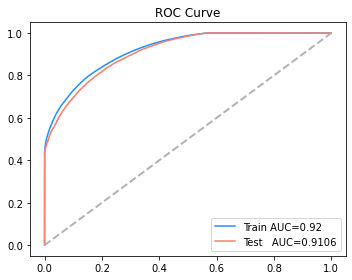

In [525]:
fpr_dev, tpr_dev, _ = roc_curve(y_dev, y_dev_score)
auc_dev = roc_auc_score(y_dev, y_dev_score)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_score)
auc_test = roc_auc_score(y_test, y_test_score)

fig, ax = plt.subplots(figsize=(5,4), tight_layout=True)
ax.plot(fpr_dev, tpr_dev, color='dodgerblue', label=f'Train AUC={round(auc_dev,4)}')
ax.plot(fpr_test, tpr_test, color='salmon', label=f'Test   AUC={round(auc_test,4)}')
ax.plot([0, 1], [0, 1], color='.7', lw=2, linestyle='--')
ax.set_title('ROC Curve')
ax.legend(loc=4)
plt.show()

## Precision / Recall / F1

In [526]:
print('='*20, 'Train', '='*20)
print(classification_report(y_dev, y_dev_pred))
print('='*20, 'Test', '='*20)
print(classification_report(y_test, y_test_pred))

==================== Train ====================
              precision    recall  f1-score   support

           0       0.46      0.83      0.59     39990
           1       0.96      0.81      0.88    213466

    accuracy                           0.82    253456
   macro avg       0.71      0.82      0.74    253456
weighted avg       0.88      0.82      0.84    253456

==================== Test ====================
              precision    recall  f1-score   support

           0       0.44      0.81      0.57      9959
           1       0.96      0.81      0.88     53406

    accuracy                           0.81     63365
   macro avg       0.70      0.81      0.73     63365
weighted avg       0.88      0.81      0.83     63365



`Precision` should be what we focus and it's 0.96 on test set.

Since our positive label is 'Fully Paid', that means from the predicted positive borrowers, how many are classified as Fully Paid correctly.

This should also align with the business operation in a way that if they 'trust' the model and approve the loan requests for `100` customers, `96` customers are correctly classified as Fully Paid.

## Score distribution

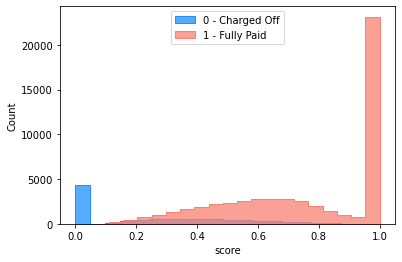

In [562]:
ax = sns.histplot(data=df[df.ground_truth==0], x='score', element='step',
                  stat='count', bins=20, label='0 - Charged Off', color='dodgerblue')
ax = sns.histplot(data=df[df.ground_truth==1], x='score', element='step',
                  stat='count', bins=20, ax=ax, label='1 - Fully Paid', color='salmon')
plt.legend(loc='upper center')
plt.show()

### Normalized Score Distribution

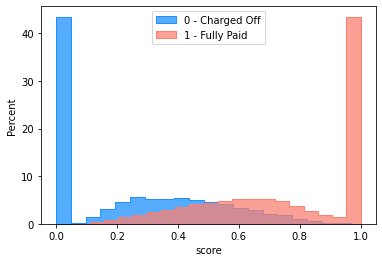

In [563]:
ax = sns.histplot(data=df[df.ground_truth==0], x='score', element='step',
                  stat='percent', bins=20, label='0 - Charged Off', color='dodgerblue')
ax = sns.histplot(data=df[df.ground_truth==1], x='score', element='step',
                  stat='percent', bins=20, ax=ax, label='1 - Fully Paid', color='salmon')
plt.legend(loc='upper center')
plt.show()

# Model Insights

## Feature Importance

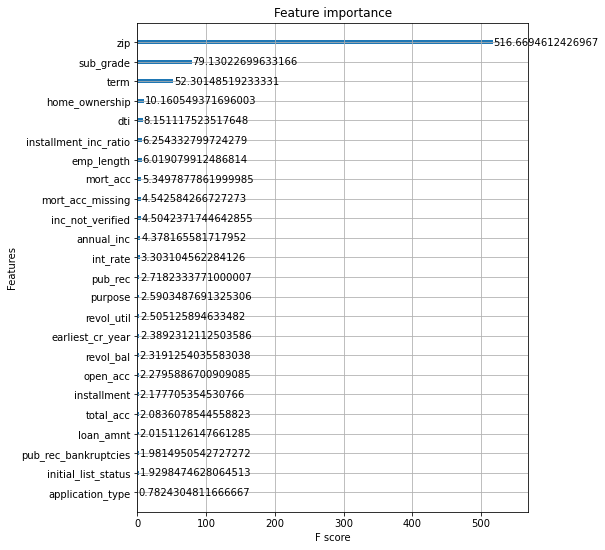

In [564]:
fig, ax = plt.subplots(figsize=(7,9))
plot_importance(model, ax=ax, importance_type='gain')
plt.show()

## Permutation Importance

In [565]:
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=random_state).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.1147 ± 0.0027,zip
0.0153 ± 0.0012,revol_bal
0.0149 ± 0.0026,sub_grade
0.0100 ± 0.0010,installment
0.0051 ± 0.0006,loan_amnt
0.0045 ± 0.0006,earliest_cr_year
0.0038 ± 0.0010,annual_inc
0.0037 ± 0.0008,revol_util
0.0030 ± 0.0004,term
0.0024 ± 0.0009,emp_length


## SHAP

In [566]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

### Summary Plot

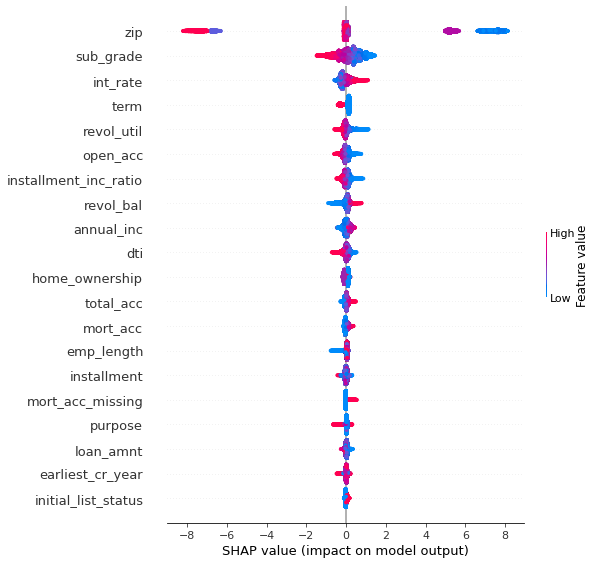

In [567]:
shap.summary_plot(shap_values, X_test)

### Mean SHAP Plot

For a brief explanation of feature impact on the probability. Same with summary plot but without direction.

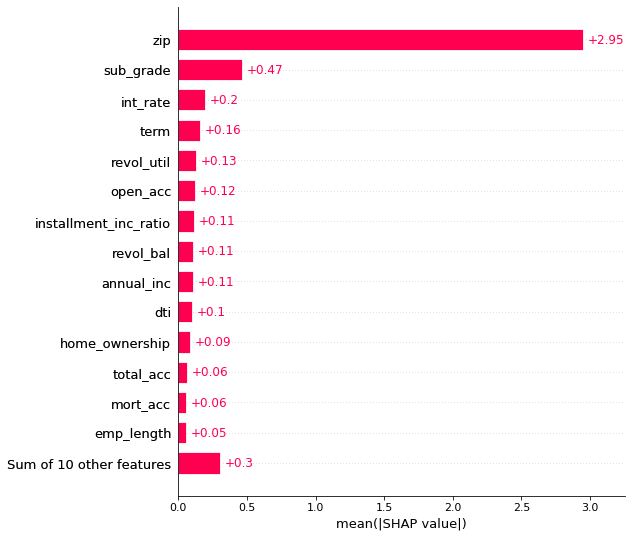

In [568]:
shap.plots.bar(explainer(X_test), max_display=15)